Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from tqdm import notebook
import matplotlib.pyplot as plt
import torch
import transformers

import re

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer # мешок слов
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF
from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
pd.set_option('max_colwidth', 100)

In [3]:
# универсальное чтение данных
name = 'toxic_comments.csv'

try:
    # local
    data = pd.read_csv("./datasets/" + name)
except:
    try:
        # https://jupyterhub.praktikum-services.ru/
        data = pd.read_csv("/datasets/" + name)
    except:
        # https://praktikum.yandex.ru/
        data = pd.read_csv("https://..." + name)
finally:
#     original_data = data.copy() 
    print(data.info())
    display(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


,text,toxic
0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


## Очистка текста

In [4]:
# удаляем с помощью регулярок символы не состоящие в алфавите
def clear_text(text): # строка на вход
    pattern = r'[^a-zA-Z ]'
    new_text = re.sub(pattern, ' ', text)
    new_text = ' '.join(new_text.split())
    return new_text # строка на выход

In [5]:
data['text'] = data['text'].apply(clear_text)

## Леммантизация

In [6]:
stemmer = SnowballStemmer("english")
def lemmatize(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

Для отображения прогресса

In [7]:
notebook.tqdm.pandas()
data['lemm'] = data.text.progress_apply(lemmatize)

C:\Users\stask\anaconda3\envs\practicum\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Разделение данных

При анализе нужно учитывать наличие дисбаланса классов

In [8]:
print('Balance:', data.toxic.mean())

Balance: 0.10167887648758234


In [9]:
train, test = train_test_split(data, random_state=12345, test_size=0.25, stratify=data.toxic)

In [10]:
print('train balance:', train.toxic.mean())
print('test balance:', test.toxic.mean())

train balance: 0.10168117782716957
test balance: 0.1016719725265084


## TF-IDF

In [11]:
# выделяем корпус текстов из данных train
corpus = train['lemm'].values

In [12]:
# для преобразования TF-IDF не будем учитывать слова, не несущие смысловой нагрузки
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# инициализируем счетчик TF-IDF
tf_model = TfidfVectorizer(stop_words=stopwords)

# обучааем и преобразуем корпус слов на выборке train
tf_idf_train = tf_model.fit_transform(corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stask\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# преобразуем корпус слов выборки test
tf_idf_test = tf_model.transform(test['lemm'].values)

# 2.1. Обучение после TF-IDF

## LogisticRegression

Подбор гиперпараметров закомментировал, т.к. обучался локально на хорошей мощности

In [14]:
%%time
model = LogisticRegression(solver='saga', C=13, random_state=12345)
model.fit(tf_idf_train, train.toxic.values)

Wall time: 6.65 s


LogisticRegression(C=13, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
predicted = model.predict(tf_idf_test)
print("Test f1: {:.4f}".format(f1_score(predicted, test.toxic.values)))

Test f1: 0.7875


Формально, требуемое значение метрики F1 достигнуто, смотрим, что можно еще выжать

<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
    <font color='green'> <b><u>КОММЕНТАРИЙ РЕВЬЮЕРА</u></b>
</font>
<font color='green'><br>отлично!

### Оценка F1 при изменении порога

In [16]:
# посмотрим, можно ли еще повысить метрику модели
model = LogisticRegression(solver='saga', C=13, random_state=12345)
model.fit(tf_idf_train, train.toxic.values)
probabilities_valid = model.predict_proba(tf_idf_test)
probabilities_one_valid = probabilities_valid[:, 1]

# данные для графика
y = pd.Series(index=np.arange(0, 1, 0.01))

for threshold in y.index:
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(test.toxic.values, predicted_valid)
    y[threshold] = f1
    
#     print("Порог = {:.2f} | F1 = {:.4f}".format(threshold, f1))

C:\Users\stask\anaconda3\envs\practicum\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


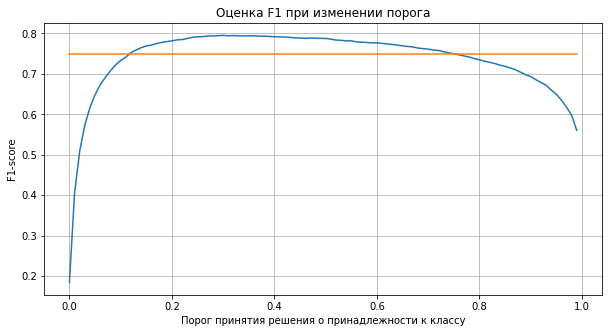

In [17]:
# кривая F1
y.plot(grid=True, figsize=(10,5), title='Оценка F1 при изменении порога')
# пороговое значение 0.75 по заданию
plt.plot(y.index, [0.75]*len(y))

plt.xlabel('Порог принятия решения о принадлежности к классу')
plt.ylabel('F1-score')
plt.show()

При изменении порога принятия решения возможно еще немного увеличить метрику.

PS: Я знаю, что на тесте не корректно выбирать порог, поэтому график нарисован по тестовой выборке просто для наглядности

## RandomForestClassifier

Подбор гиперпараметров и обучение закомментировал, т.к. обучался локально на хорошей мощности

Случайный лес гораздо сложнее настроить, так как обучение происходит значительно медленнее. При этом значение метрики не дотягивает до порогового значения.

## LGBMClassifier

Подбор гиперпараметров закомментировал

Модель с дефолтными параметрами дает результат лучше, чем при попытке подбора других гиперпараметров. Поэтому просто добавим количество деревьев (немного улучшает score)

Значение метрики модели практически совпадает с логистической регрессией, но скорость вычислений гораздо больше.

# 2.2. Обучение с BERT
PS: Вычисления ниже, моя попытка разобраться как работать с BERT. Код заключен в RAW ячейки, т.к. многие вычисления могут быть долгими

## BERT: 1 вариант работы
Обучимся на несбалансированных данных

!!! код ниже выполняется 40 минут

При обучении на несбалансированной получаем весьма скромные результаты. Пробуем сбалансировать

## BERT: 2 вариант работы
Пробуем обучить модель на сбалансированных данных, проверить результат на реальных (несбалансированных)

### train
Сбалансированные данные для обучения

!!! код ниже выполняется 40 минут

### test
Несбалансированные данные для теста

!!! код ниже выполняется 5 минут

### Модель

Результат даже хуже, чем в первом варианте

# 3. Выводы

Лучшее значение F1 метрики показала **линейная регрессия** после преобразования **TF-IDF**: **0.7875**

Близко к этому значения подбирается LightGBM, но проигрывает по скорости.

Интернет-магазин «Викишоп» в качестве инстумента для определения токсичных комментариев может использовать следующий алгоритм:
- [Очистка текстов от лишних символов](#Очистка-текста)
- [Леммантизация слов](#Леммантизация)
- [Рассчет TF-IDF для слов](#TF-IDF)
- [Модель LogisticRegression](#LogisticRegression)